# Third-party software computation model example

## Introduction

This example file demonstrates how to build a RunModel object which enables UQpy to execute models in third-party software. The files necessary to run this example are:
1. The input template - 'abaqus_input.py'
2. The model script - 'abaqus_fire_analysis.py'
3. The output script - 'extract_abaqus_output.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus. 

## Description of the model

This example builds and analyzes a finite element model of a beam bearing uniformly distributed load, which is then subjected to fire load.  

## The script:

Import the python modules used in this example, note down the start time and the current directory, which will be used later to save the results.

In [1]:
from UQpy.RunModel import *
from UQpy.SampleMethods import STS, MCS
import time
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.art3d as art3d

calling_directory = os.getcwd()
t = time.time()

### Building the model:

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

#### Create the model object

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_fire_analysis.py', input_template='abaqus_input.py',
                            output_script='extract_abaqus_output.py',
                            var_names=var_names, ntasks=1, model_dir='SFE_Example', verbose=True)
print('Example: Created the model object.')

No samples. Creating the object alone.
Example: Created the model object.


### Drawing samples

The fire load density is assumed to be uniformly distributed between 50 MJ/m^2 and 450 MJ/m^2. The yield strength is assumed to be normally distributed, with the parameters being: mean = 250 MPa and coefficient of variation of 7%.

### Using MCS class in UQpy for simple random sampling

In [4]:
# Creating samples using MCS
x_mcs = MCS(dist_name=['uniform', 'normal'], dist_params=[[50, 400], 
            [2.50e8, 1.75e7]], nsamples=10)
print('Example: Created MCS samples. They are:')
print(x_mcs.samples)# Running simulations using the previously defined model object and samples

Example: Created MCS samples. They are:
[[2.98568723e+02 2.37266422e+08]
 [1.55029202e+02 2.43385158e+08]
 [3.70639812e+02 2.53592931e+08]
 [4.13169187e+02 2.61642442e+08]
 [3.89302949e+02 2.66134288e+08]
 [1.55966694e+02 2.41909445e+08]
 [2.18362692e+02 2.70012850e+08]
 [1.43937919e+02 2.37308463e+08]
 [3.20061161e+02 2.74949536e+08]
 [1.15387220e+02 2.69384787e+08]]


### Propagating MCS inputs through the model

In [5]:
sample_points = x_mcs.samples
abaqus_sfe_model.run(samples=sample_points)

The output function that will be run: extract_disp_temp_output

Performing serial execution of the model with template input.

Found 1 instance of variable: 'qtd' in the input file.
Found 1 instance of variable: 'fy' in the input file.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.
Out:  0
Example: Successful output extraction.


### Saving the MCS results

In [6]:
# The output from each analysis is the difference between the maximum allowable displacement and the 
# maximum displacement of the midpoint of the beam.
qois = abaqus_sfe_model.qoi_list

# Save the samples and the qois in a dictionary called results with keys 'inputs' and 'outputs'
results = {'inputs': sample_points, 'outputs': qois}

# Pickle the results dictionary in the current directory. The basename and extension of the desired pickle file:
res_basename = 'MCS_results'
res_extension = '.pkl'

# Create a new results file with a larger index than any existing results files with the same name in the current
# directory.
res_file_list = glob.glob(res_basename + '_???' + res_extension)
if len(res_file_list) == 0:
    res_file_name = res_basename + '_000' + res_extension
else:
    max_number = max(res_file_list).split('.')[0].split('_')[-1]
    res_file_name = res_basename + '_%03d' % (int(max_number) + 1) + res_extension

res_file_name = os.path.join(calling_directory, res_file_name)
# Save the results to this new file.
with open(res_file_name, 'wb') as f:
    pickle.dump(results, f)
print('Saved the results to ' + res_file_name)

Saved the results to C:\Users\Aakash\Documents\UQpy_paper-master\SampleMethods\Abaqus-Sampling\MCS_results_000.pkl


### Plotting the results

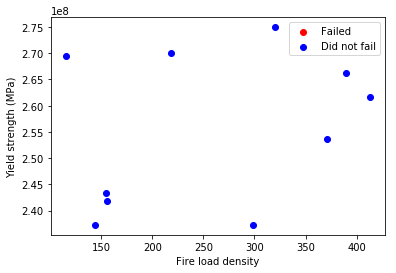

Probability of failure using 10 samples:  0.000000


In [7]:
# Load the results from the latest pickle dump.
with open(res_file_name, 'rb') as f:
    results = pickle.load(f)

# Use the values loaded from pickle file.
sample_points = results['inputs']
Y = np.array(results['outputs'])

x = sample_points[:, 0]
y = sample_points[:, 1]

# 2D plot showing success or failure
fig = plt.figure()
ax = fig.add_subplot(111)
p3 = ax.scatter(x[Y < 0], y[Y < 0], color='Red', label='Failed')
p4 = ax.scatter(x[Y >= 0], y[Y >= 0], color='Blue', label='Did not fail')
ax.set_xlabel('Fire load density')
ax.set_ylabel('Yield strength (MPa)')
plt.legend()
plt.show()
    
# Compute probability of failure
probability_of_failure = len(Y[Y < 0])/len(Y)
print('Probability of failure using %d samples: % 0.6f' % (len(Y), probability_of_failure))

In [8]:
print('Example: Done!')
print('Time elapsed: %.2f minutes' % float((time.time() - t) / 60.0))

Example: Done!
Time elapsed: 7.20 minutes
